In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import math
import glob
import time
from datetime import date
from typing import Tuple, Union

import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm_notebook as tqdm
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

2024-12-19 08:46:15.853591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734597975.874255  208765 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734597975.880613  208765 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
#--------------------- for working with directory ----------------------------
ROOT_DATA_PATH='/workspace/datasets'
DATASET_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-hemorrhage-detection'

TRAIN_DATA_PATH=f'{DATASET_PATH}/stage_2_train'
TRAIN_METADATA_PATH=f'{DATASET_PATH}/processed_metadata/train_metadata_df.pkl'

SEED = 666

In [3]:
#seeding
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
class ImagePreparationUtil:
    @staticmethod
    def correct_dcm(dcm: pydicom.FileDataset):
        x = dcm.pixel_array
        x = x + 1000
        px_mode = 4096
        x[x >= px_mode] = x[x >= px_mode] - px_mode
        dcm.PixelData = x.tobytes()
        dcm.RescaleIntercept = -1000
        
    @staticmethod
    def window_image(dcm: pydicom.FileDataset, window_center: int, window_width: int):
        if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
            ImagePreparationUtil.correct_dcm(dcm)
        
        # Pixel to Hounsfield Unit (HU)
        # HU=(Pixel Value×RescaleSlope)+RescaleIntercept
        img = dcm.pixel_array
        img = img * dcm.RescaleSlope + dcm.RescaleIntercept 
        img_min = window_center - window_width // 2
        img_max = window_center + window_width // 2
        img = np.clip(img, img_min, img_max)
        
        return img
    
    @staticmethod
    def get_windowed_image(dcm: pydicom.FileDataset, window: Union['brain', 'subdural', 'soft'] = 'brain') -> np.ndarray: # type: ignore
        im = None
        match window:
            case 'brain':
                brain_img = ImagePreparationUtil.window_image(dcm, 40, 80)
                brain_img = (brain_img - 0) / 80
                im = brain_img
            case 'subdural':
                subdural_img = ImagePreparationUtil.window_image(dcm, 80, 200)
                subdural_img = (subdural_img - (-20)) / 200
                im = subdural_img
            case 'soft':
                soft_img = ImagePreparationUtil.window_image(dcm, 40, 380)
                soft_img = (soft_img - (-150)) / 380
                im = soft_img
            case _:
                raise ValueError('invalid window argument')
        
        return im
    
    @staticmethod
    def bsb_window(dcm):
        brain_img = ImagePreparationUtil.get_windowed_image(dcm, window='brain')
        subdural_img = ImagePreparationUtil.get_windowed_image(dcm, window='subdural')
        soft_img = ImagePreparationUtil.get_windowed_image(dcm, window='soft')

        bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

        return bsb_img
    
    @staticmethod
    def read(path, resize: Tuple[int, int]):
        img = None
        try:
            dcm = pydicom.dcmread(path)
            img = ImagePreparationUtil.bsb_window(dcm)
        except Exception as e:
            print('\nWarning:', e.__class__.__name__, f'for {path} Replacing with zeros image')
            img = np.zeros((*tuple(resize[:2]), 3), dtype=np.float32)
        
        if resize is not None:
            img = cv2.resize(img, resize[:2], interpolation=cv2.INTER_LINEAR)
            
        return img.astype(np.float32)

In [5]:
class TrainDataGenerator(keras.utils.Sequence):
    def __init__(self, img_ids, labels, img_dir, img_shape, num_classes, batch_size, under_sampling=False, shuffle_on_epoch_end=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.img_ids = img_ids
        self.labels = labels
        self.img_dir = img_dir
        self.img_shape = img_shape
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.under_sampling = under_sampling
        self.shuffle_on_epoch_end = shuffle_on_epoch_end
        self.on_epoch_end()
    
    def __len__(self):
        return math.ceil(len(self.img_ids) / self.batch_size)

    def __getitem__(self, index):
        low = index*self.batch_size
        high = min(low + self.batch_size, len(self.img_ids))
        indices = self.indices[low:high]
        X,y = self.__data_generation(indices)

        return X,y
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.img_ids))
        
        if self.under_sampling:
            keep_prob = self.labels.iloc[:,0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = self.indices[keep]
            
        if self.shuffle_on_epoch_end:
            np.random.shuffle(self.indices)

        
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_shape))
        y = np.empty((self.batch_size, self.num_classes), dtype=np.float32)
        
        for i, img_idx in enumerate(indices):
            img_id = self.img_ids[img_idx]
            img_path = f'{self.img_dir}/{img_id}.dcm'
            img = ImagePreparationUtil.read(img_path, self.img_shape[:2])
            X[i,] = img
            y[i,] = self.labels.iloc[img_idx].values
            
        return X,y
         

In [6]:
df = pd.read_pickle(TRAIN_METADATA_PATH)
test_df_neg = df[df['Label']['any'] == 0].sample(n=200)
test_df_pos = df[df['Label']['any'] == 1].sample(n=200)
test_df = pd.concat([test_df_pos, test_df_neg]).sample(frac=1)
df = df.drop(test_df.index)
df

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_99196d0ab     1        0                0                0            0   
ID_2b0190b58     0        0                0                0            0   
ID_056e14224     1        1                0                0            0   
ID_525e72262     0        0                0                0            0   
ID_b00eddf10     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_21e825c20     0        0                0                0            0   
ID_85141c704     1        0                1                0            0   
ID_b4add57dd     0        0                0                0            0   
ID_02f0d7dbb     0        0                0                0            0   
ID_7d29263ce     1        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_99196d0ab        1  
ID_2b0190b58        0  
ID_056e14224        0  
ID_525e72262        0  
ID_b00eddf10        0  
...               ...  
ID_21e825c20        0  
ID_85141c704        1  
ID_b4add57dd        0  
ID_02f0d7dbb        0  
ID_7d29263ce        1  

[263606 rows x 6 columns]

In [7]:
df['Label']['any'].value_counts()

any
0    146510
1    117096
Name: count, dtype: int64

In [8]:
test_df['Label']['any'].value_counts()

any
1    200
0    200
Name: count, dtype: int64

In [9]:
class LearningRateLogger(keras.callbacks.Callback):        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        logs['learning_rate'] = float(tf.keras.backend.get_value(lr))
        print(f"Epoch {epoch + 1}: Learning rate is {logs['learning_rate']}")
        
class DeepModel():
    def __init__(self, base,input_shape, batch_size, num_epochs, num_classes, learning_rate, decay_rate, decay_steps, base_name='base_model', weights='imagenet', freeze_base=False, saving_path=None, verbose=1):
        self.base = base
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.base_name = base_name
        self.weights = weights
        self.freeze_base = freeze_base
        self.saving_path = saving_path
        self.verbose = verbose
        self._build()
        self._create_saving_path_if_none()
    
    def _build(self):
        K.clear_session()
        base = self.base(include_top=False, weights=self.weights, pooling='avg', input_shape=self.input_shape)
        base.trainable = not self.freeze_base
            
        x = base.output
        x = layers.Dropout(0.2)(x)
        out = layers.Dense(self.num_classes, activation='sigmoid', name='dense_output')(x)
        
        self.model = keras.models.Model(inputs=base.input, outputs=out)
        
        self.model.compile(
            loss=keras.losses.BinaryCrossentropy(), 
            optimizer=keras.optimizers.AdamW(learning_rate=self.learning_rate),
            metrics=[
                keras.metrics.TruePositives(name='tp'),
                keras.metrics.TrueNegatives(name='tn'),
                keras.metrics.FalsePositives(name='fp'),
                keras.metrics.FalseNegatives(name='fn'),
                keras.metrics.BinaryAccuracy(name='binary_acc'), 
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='auc_roc', curve='ROC', multi_label=True, num_labels=self.num_classes),
                keras.metrics.AUC(name='auc_pr', curve='PR', multi_label=True, num_labels=self.num_classes),
                keras.metrics.F1Score(name='f1_score', average='macro'),                
            ]
        )
        
    def _create_saving_path_if_none(self):
        if self.saving_path is None:
            print('saving_path is None. Automatically create path for save training utilities')
            saving_path = os.path.join('saved_model', self.base.__name__)
            os.makedirs(saving_path, exist_ok=True)
            self.saving_path = saving_path
            print(self.saving_path, 'created for saving_path')
        
    def fit(self, train_df, valid_df):
        train_data_gen = TrainDataGenerator(
            img_ids=train_df.index, 
            labels=train_df,
            img_dir=TRAIN_DATA_PATH,
            img_shape=self.input_shape,
            num_classes=self.num_classes,
            batch_size=self.batch_size,
            under_sampling=False,
            workers=128,
            use_multiprocessing=True
        )
        
        valid_data_gen = TrainDataGenerator(
            img_ids=valid_df.index, 
            labels=valid_df,
            img_dir=TRAIN_DATA_PATH,
            img_shape=self.input_shape,
            num_classes=self.num_classes,
            batch_size=self.batch_size,
            under_sampling=False,
            workers=128,
            use_multiprocessing=True
        )
        
        curr_time = int(time.time())
        callbacks = [
            keras.callbacks.ModelCheckpoint(filepath='%s/{epoch:02d}-%s.weights.h5' % (self.saving_path, curr_time), monitor='val_loss', mode='min', verbose=self.verbose, save_weights_only=True, save_best_only=True),
            keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, math.floor(epoch / self.decay_steps)), verbose=1),
            keras.callbacks.EarlyStopping(verbose=1, restore_best_weights=True, monitor='val_loss', patience=4, mode='min'),
            keras.callbacks.CSVLogger(filename='%s/%s.csv'%(self.saving_path, f'{curr_time}-train_log'))
        ]
        return self.model.fit(
            x=train_data_gen,
            validation_data=valid_data_gen,
            callbacks=callbacks,
            epochs=self.num_epochs,
            verbose=self.verbose
        )
    
    def save(self, filename, overwrite=True):
        _, ext = os.path.splitext(filename)
        if ext != '.keras':
          filename = f'{filename}.keras'
          
        p = os.path.join(self.saving_path, filename)
        self.model.save(p, overwrite=overwrite)
        print('model saved to:', p)
        
    def load_weights(self, path, *args, **kwargs):
        self.model.load_weights(path, *args, **kwargs)
        
    def load(self, path, *args, **kwargs):
        self.model = keras.models.load_model(path, *args, **kwargs)
        

In [10]:
EPOCH = 15
INPUT_SHAPE = (256, 256, 3)
BATCH_SIZE = 32
N_CLASSES = 6
INITIAL_LEARNING_RATE = 0.000125

In [11]:
msss = MultilabelStratifiedShuffleSplit(n_splits=EPOCH, test_size=0.15, random_state=SEED)
X = df.index
Y = df['Label'].values

msss_splits = next(msss.split(X, Y))
train_idx = msss_splits[0]
valid_idx = msss_splits[1]

In [12]:
saving_path = 'saved_model/02_EfficientNetB4_V2_image_input'
os.makedirs(saving_path, exist_ok=True)

model = DeepModel(
    base=keras.applications.EfficientNetB4,
    weights='imagenet',
    freeze_base=False,
    input_shape=INPUT_SHAPE, 
    batch_size=BATCH_SIZE, 
    num_epochs=EPOCH,
    num_classes=N_CLASSES,
    learning_rate=INITIAL_LEARNING_RATE, 
    decay_rate=0.75, 
    decay_steps=1,
    base_name='efficientnetb4',
    saving_path=saving_path
)

I0000 00:00:1734598139.416366  208765 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8225 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.10gb, pci bus id: 0000:07:00.0, compute capability: 8.0


In [ ]:
np.random.shuffle(train_idx)

hist = model.fit(df.iloc[train_idx], df.iloc[valid_idx])
model.save('Best_EfficientNetB4_V2_image_input.keras')


Epoch 1: LearningRateScheduler setting learning rate to 0.000125.
Epoch 1/15


I0000 00:00:1734598259.284828  209311 service.cc:148] XLA service 0x7f22c8003080 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734598259.284867  209311 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 1g.10gb, Compute Capability 8.0
I0000 00:00:1734598268.568606  209311 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1734598332.683982  209311 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7003/7003 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - auc_pr: 0.7111 - auc_roc: 0.9133 - binary_acc: 0.9087 - f1_score: 0.1671 - fn: 37358.4453 - fp: 17077.5156 - loss: 0.2244 - precision: 0.8009 - recall: 0.6506 - tn: 535779.1875 - tp: 82168.8438
Epoch 1: val_loss improved from inf to 0.20886, saving model to saved_model/02_EfficientNetB4_V2_image_input/01-1734598159.weights.h5
7003/7003 ━━━━━━━━━━━━━━━━━━━━ 3157s 426ms/step - auc_pr: 0.7112 - auc_roc: 0.9133 - binary_acc: 0.9087 - f1_score: 0.1671 - fn: 37362.6211 - fp: 17079.5781 - loss: 0.2244 - precision: 0.8009 - recall: 0.6506 - tn: 535856.0625 - tp: 82181.6875 - val_auc_pr: 0.8133 - val_auc_roc: 0.9378 - val_binary_acc: 0.9228 - val_f1_score: 0.2376 - val_fn: 14630.0000 - val_fp: 3692.0000 - val_loss: 0.2089 - val_precision: 0.8819 - val_recall: 0.6533 - val_tn: 191426.0000 - val_tp: 27564.0000 - learning_rate: 1.2500e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.375e-05.
Epoch 2/15
7003/7003 ━━━━━━━━━━━━━━━━━━━━ 0s 3

In [21]:
logpath = os.path.join(model.saving_path, '1734598159-train_log.csv') 
train_history = pd.read_csv(logpath)
# train_history['epoch'] = train_history['epoch']+1
# train_history.to_csv(logpath, index=False)

In [22]:
train_history

,epoch,auc_pr,auc_roc,binary_acc,f1_score,fn,fp,learning_rate,loss,precision,...,val_auc_roc,val_binary_acc,val_f1_score,val_fn,val_fp,val_loss,val_precision,val_recall,val_tn,val_tp
0,1,0.806094,0.946602,0.926996,0.196068,66626.0,31532.0,0.000125,0.184047,0.845173,...,0.937760,0.922793,0.237617,14630.0,3692.0,0.208861,0.881879,0.653268,191426.0,27564.0
1,2,0.919858,0.976883,0.952972,0.292444,40401.0,22834.0,0.000094,0.122276,0.896769,...,0.873250,0.887326,0.221998,25466.0,1273.0,0.364506,0.929297,0.396512,193841.0,16732.0
2,3,0.955047,0.987399,0.965910,0.326579,28190.0,17648.0,0.000070,0.089058,0.922666,...,0.662077,0.831559,0.245926,39843.0,130.0,1.382112,0.947623,0.055741,194987.0,2352.0
3,4,0.976123,0.993713,0.976958,0.321639,18624.0,12355.0,0.000053,0.061240,0.946861,...,0.963856,0.947267,0.284549,9081.0,3433.0,0.164346,0.906074,0.784800,191681.0,33117.0
4,5,0.988218,0.997089,0.984898,0.320537,11823.0,8480.0,0.000040,0.040506,0.963978,...,0.952508,0.936122,0.282733,9361.0,5798.0,0.200800,0.849921,0.778154,189318.0,32835.0
5,6,0.994029,0.998536,0.989943,0.320557,7735.0,5784.0,0.000030,0.027294,0.975574,...,0.974256,0.958970,0.349519,4765.0,4972.0,0.149818,0.882764,0.887093,190137.0,37438.0
6,7,0.996361,0.999065,0.992799,0.333055,5527.0,4150.0,0.000022,0.020285,0.982518,...,0.970413,0.958674,0.316681,5374.0,4433.0,0.159147,0.892557,0.872654,190679.0,36826.0
7,8,0.997669,0.999366,0.994540,0.342236,4146.0,3187.0,0.000017,0.015604,0.986598,...,0.958800,0.951326,0.324021,7054.0,4497.0,0.209761,0.886571,0.832855,190612.0,35149.0
8,9,0.998346,0.999549,0.995579,0.341955,3297.0,2638.0,0.000013,0.012631,0.988921,...,0.969178,0.962859,0.368109,4939.0,3875.0,0.169771,0.905816,0.882981,191230.0,37268.0
9,10,0.998823,0.999702,0.996298,0.355290,2745.0,2224.0,0.000009,0.010566,0.990665,...,0.968304,0.959943,0.363187,4866.0,4640.0,0.180246,0.889458,0.884695,190471.0,37335.0


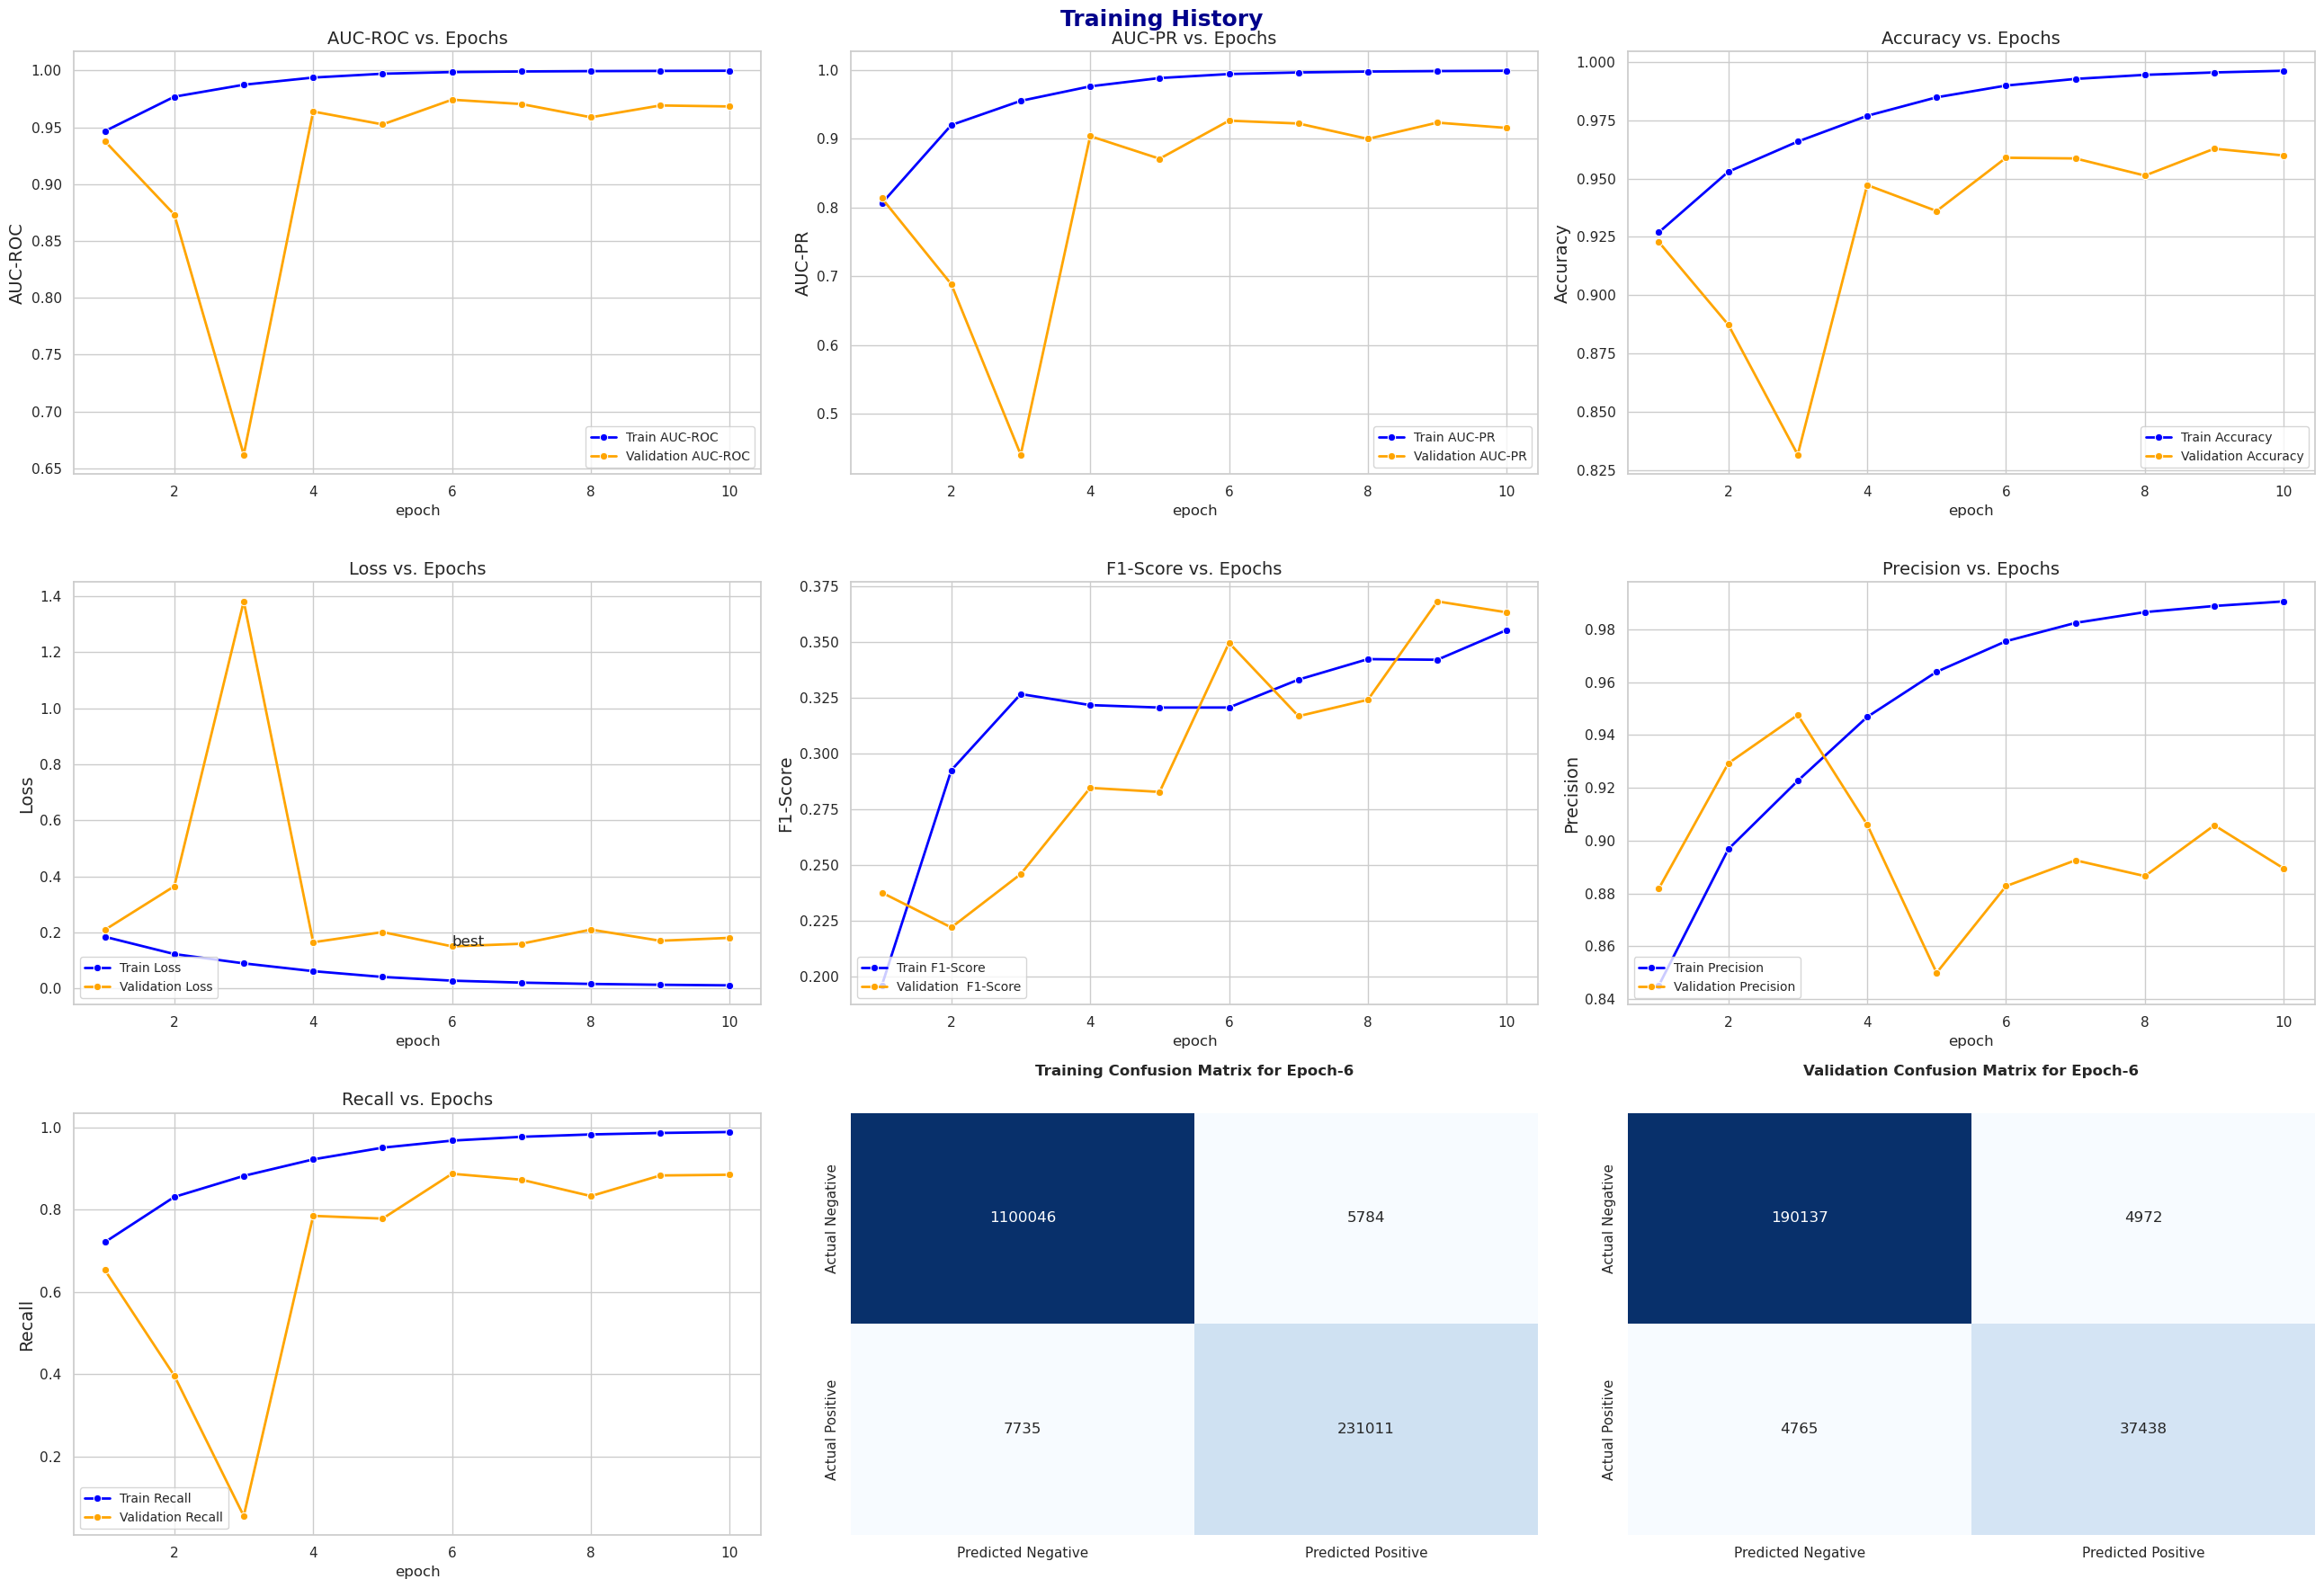

In [26]:
# auc_roc auc_pr bin_acc
# loss f1_score precision
# recall
best = lambda idx, x_col, y_col: (train_history.iloc[idx][x_col],train_history.iloc[idx][y_col])
best_epoch = 6
# Set seaborn theme
sns.set_theme(style="whitegrid")

# Create the figure and axes
fig, axes = plt.subplots(3, 3, figsize=(26, 18), sharey=False)
fig.suptitle("Training History", fontsize=18, fontweight="bold", color="darkblue")

# 1st subplot: AUC-ROC
sns.lineplot(data=train_history, x='epoch', y='auc_roc', label='Train AUC-ROC', ax=axes[0, 0], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_auc_roc', label='Validation AUC-ROC', ax=axes[0, 0], color='orange', linewidth=2, marker='o')
# lambda arguments : expression
# axes[0].annotate(text='best', xy=best('epoch', 'val_auc_roc'))
axes[0, 0].set_ylabel("AUC-ROC", fontsize=14)
axes[0, 0].set_title("AUC-ROC vs. Epochs", fontsize=14)
axes[0, 0].legend(loc="lower right", fontsize=10)

# 2nd subplot: AUC-PR
sns.lineplot(data=train_history, x='epoch', y='auc_pr', label='Train AUC-PR', ax=axes[0, 1], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_auc_pr', label='Validation AUC-PR', ax=axes[0, 1], color='orange', linewidth=2, marker='o')
# lambda arguments : expression
# axes[0].annotate(text='best', xy=best('epoch', 'val_auc_roc'))
axes[0, 1].set_ylabel("AUC-PR", fontsize=14)
axes[0, 1].set_title("AUC-PR vs. Epochs", fontsize=14)
axes[0, 1].legend(loc="lower right", fontsize=10)

# 3rd subplot: Accuracy
sns.lineplot(data=train_history, x='epoch', y='binary_acc', label='Train Accuracy', ax=axes[0, 2], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_binary_acc', label='Validation Accuracy', ax=axes[0, 2], color='orange', linewidth=2, marker='o')
# axes[2].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[0, 2].set_ylabel("Accuracy", fontsize=14)
axes[0, 2].set_title("Accuracy vs. Epochs", fontsize=14)
axes[0, 2].legend(loc="lower right", fontsize=10)

# 4th subplot: Loss
sns.lineplot(data=train_history, x='epoch', y='loss', label='Train Loss', ax=axes[1, 0], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_loss', label='Validation Loss', ax=axes[1, 0], color='orange', linewidth=2, marker='o')
axes[1, 0].annotate(text='best', xy=best(best_epoch-1, 'epoch', 'val_loss'))
axes[1, 0].set_ylabel("Loss", fontsize=14)
axes[1, 0].set_title("Loss vs. Epochs", fontsize=14)
axes[1, 0].legend(loc="lower left", fontsize=10)


# 5th subplot: F1-Score
sns.lineplot(data=train_history, x='epoch', y='f1_score', label='Train F1-Score', ax=axes[1, 1], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_f1_score', label='Validation  F1-Score', ax=axes[1, 1], color='orange', linewidth=2, marker='o')
# axes[1].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[1, 1].set_ylabel("F1-Score", fontsize=14)
axes[1, 1].set_title("F1-Score vs. Epochs", fontsize=14)
axes[1, 1].legend(loc="lower left", fontsize=10)

# 6th subplot: Precision
sns.lineplot(data=train_history, x='epoch', y='precision', label='Train Precision', ax=axes[1, 2], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_precision', label='Validation Precision', ax=axes[1, 2], color='orange', linewidth=2, marker='o')
# axes[1].annotate(text='best', xy=best('epoch', 'val_precision'))
axes[1, 2].set_ylabel("Precision", fontsize=14)
axes[1, 2].set_title("Precision vs. Epochs", fontsize=14)
axes[1, 2].legend(loc="lower left", fontsize=10)

# 7th subplot: Recall
sns.lineplot(data=train_history, x='epoch', y='recall', label='Train Recall', ax=axes[2, 0], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_recall', label='Validation Recall', ax=axes[2, 0], color='orange', linewidth=2, marker='o')
# axes[1].annotate(text='best', xy=best('epoch', 'val_recall'))
axes[2, 0].set_ylabel("Recall", fontsize=14)
axes[2, 0].set_title("Recall vs. Epochs", fontsize=14)
axes[2, 0].legend(loc="lower left", fontsize=10)


# confusion matrix from best weight
row = train_history[train_history['epoch'] == best_epoch].iloc[0]

conf_matrix_training = [
    [int(row['tn']), int(row['fp'])], # [TN, FP]
    [int(row['fn']), int(row['tp'])], # [FN, TP]
]
conf_matrix_validation = [
    [int(row['val_tn']), int(row['val_fp'])],
    [int(row['val_fn']), int(row['val_tp'])],
]

# 8th subplot: Training Confusiong Matrix
sns.heatmap(conf_matrix_training, annot=True, fmt='d', cmap='Blues', cbar=False,ax=axes[2, 1], xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
axes[2, 1].set_title("Training Confusion Matrix for Epoch-6", pad=30, fontdict={'fontweight': 'bold'})

# 9th subplot: Validation Confusiong Matrix
sns.heatmap(conf_matrix_validation, annot=True, fmt='d', cmap='Blues', cbar=False,ax=axes[2, 2], xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
axes[2, 2].set_title("Validation Confusion Matrix for Epoch-6", pad=30, fontdict={'fontweight': 'bold'})

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for suptitle
plt.show()

In [27]:
test_data_gen = TrainDataGenerator(
    img_ids=test_df.index, 
    labels=test_df,
    img_dir=TRAIN_DATA_PATH,
    img_shape=INPUT_SHAPE,
    num_classes=N_CLASSES,
    batch_size=15,
    under_sampling=False,
    workers=128,
    use_multiprocessing=True
)

In [52]:
x_test, y_test = test_data_gen[5]
y_test_pred = model.model(x_test,training=False)
y_test = y_test.squeeze()
y_test_pred = y_test_pred.numpy().squeeze()

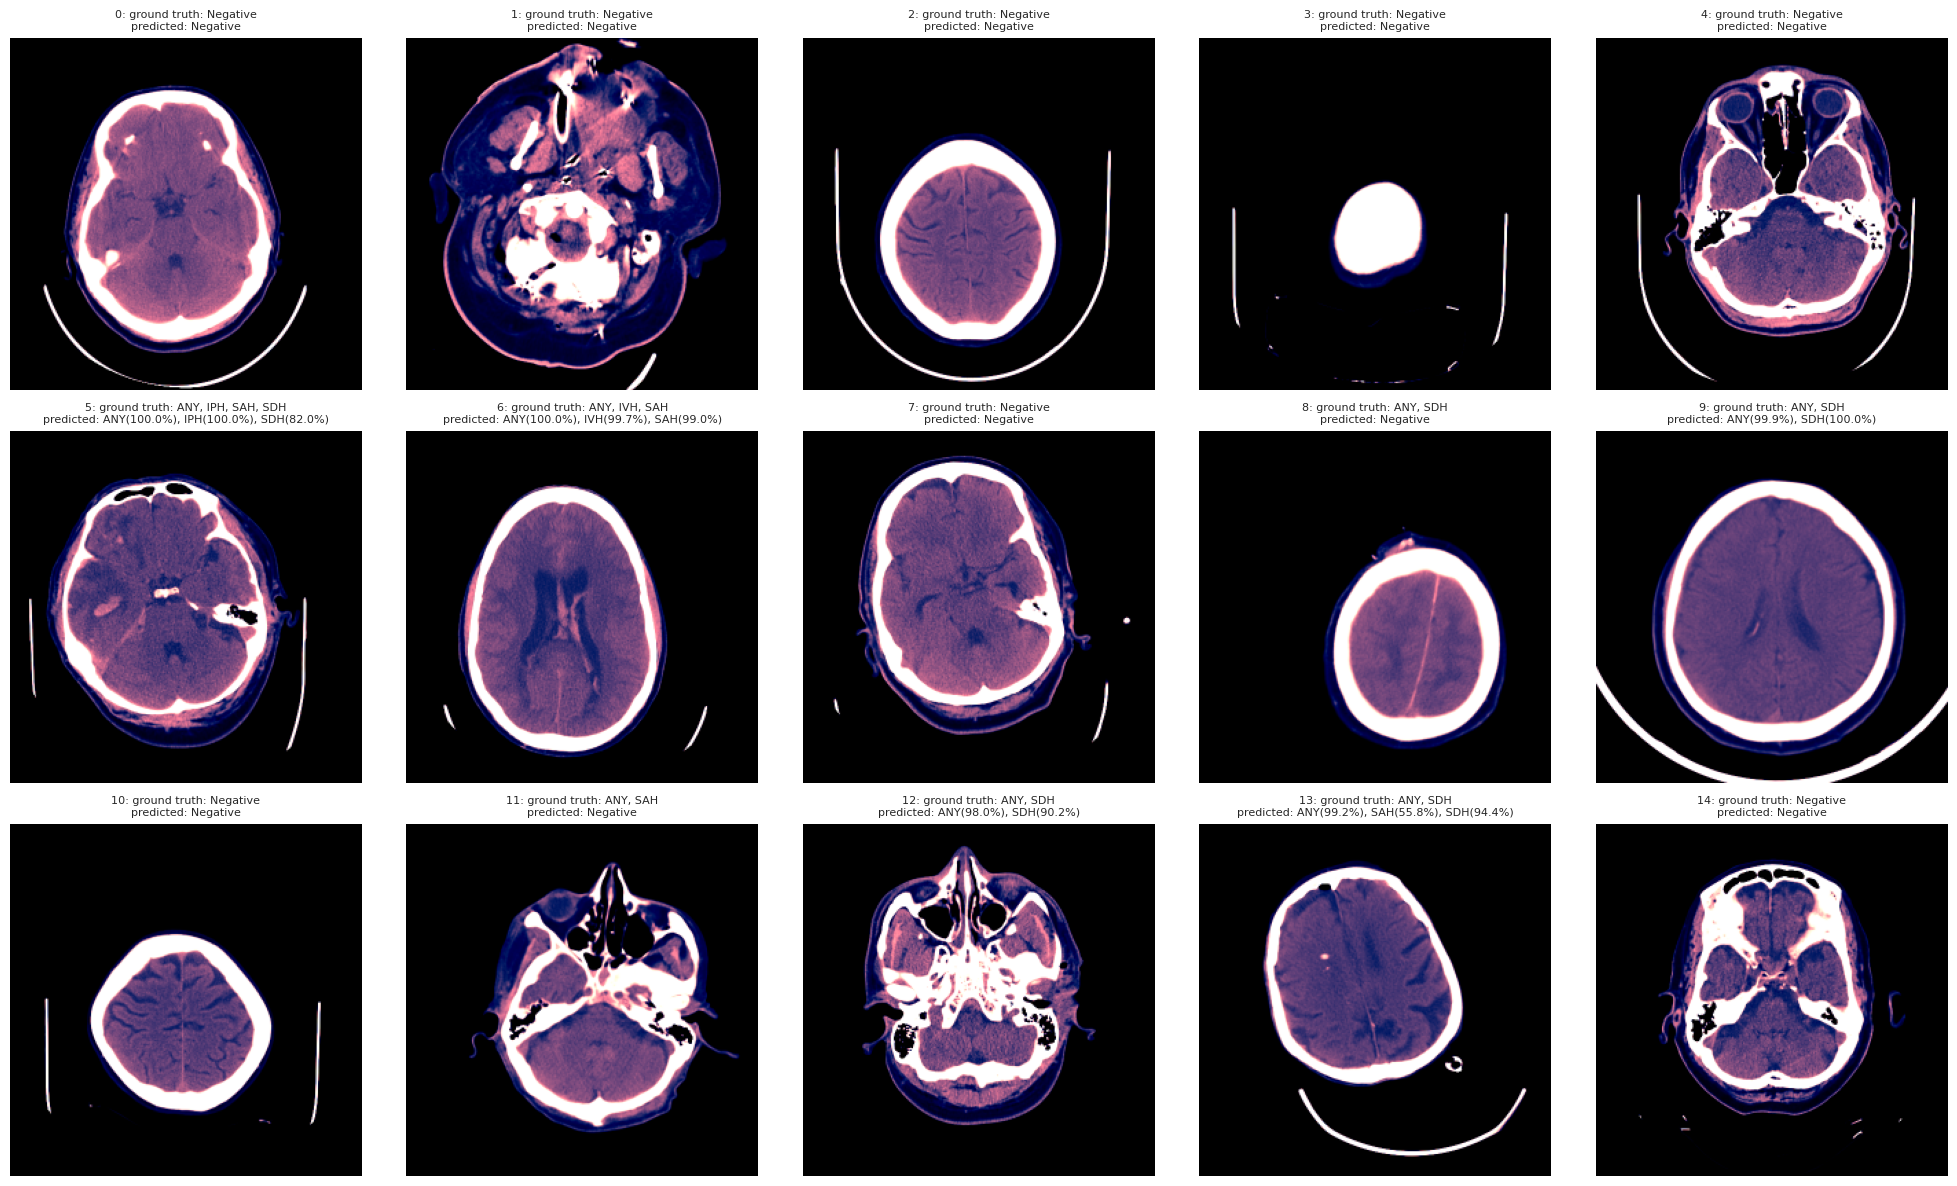

In [53]:
labels_map = {
    0: 'ANY', # any
    1: 'EDH', # epidural
    2: 'IPH', # intraparenchymal
    3: 'IVH', # intraventricular
    4: 'SAH', # subarachnoid
    5: 'SDH', # subdural
}

# sanity check
N, M = int(np.ceil(len(y_test_pred)/5)), 5
fig, axes = plt.subplots(N, M, figsize=(M*4,N*4))
for i, ax in enumerate(axes.flat):
    if i < len(y_test_pred):
        ground_truth = ", ".join([labels_map[j] for j in np.where(y_test[i] == 1)[0]])
        ground_truth = str(i) + ': ground truth: ' + (ground_truth if len(ground_truth) > 0 else 'Negative')
        
        
        predicted = ", ".join(['%s(%s)' % (labels_map[j], f'{y_test_pred[i][j]*100:0.01f}%') for j in np.where(y_test_pred[i] >= 0.5)[0]])
        predicted = '\npredicted: ' + (predicted if len(predicted) > 0 else 'Negative')
        # confidient = '\nconfidient: ' + (f'{y_test_pred[i]*100:0.001f}%' if y_test_pred[i] >= 0.5 else f'{(1-y_test_pred[i])*100:0.001f}%')
        ax.imshow(x_test[i], cmap=plt.cm.bone)
        ax.axis('off')
        ax.set_title(ground_truth + predicted)
        ax.title.set_size(8)
    else:
        ax.axis('off')

fig.tight_layout()
fig.show()

In [30]:
class GradCAM:
    def __init__(self, model, last_conv_layer_name):
        """
        Initialize the GradCAM object.

        Args:
        - model: Trained TensorFlow/Keras model.
        - last_conv_layer_name: Name of the last convolutional layer in the model.
        """
        self.model = model
        self.last_conv_layer_name = last_conv_layer_name

        # Create a model that outputs the activations of the last conv layer and predictions
        self.grad_model = tf.keras.models.Model(
            inputs=self.model.input,
            outputs=[
                self.model.get_layer(self.last_conv_layer_name).output,
                self.model.output
            ]
        )

    def compute_heatmap(self, image, class_idx):
        """
        Compute Grad-CAM heatmap for a specific class index.

        Args:
        - image: Preprocessed input image of shape (H, W, C).
        - class_idx: Index of the class to compute the Grad-CAM for.

        Returns:
        - heatmap: Grad-CAM heatmap for the given class index.
        """
        # Add a batch dimension to the image
        image = np.expand_dims(image, axis=0)

        # Record the gradients of the target class output w.r.t. the last conv layer
        with tf.GradientTape() as tape:
            conv_output, predictions = self.grad_model(image)
            target_class_output = predictions[:, class_idx]

        # Compute the gradients of the target class output with respect to conv_output
        grads = tape.gradient(target_class_output, conv_output)

        # Global average pooling of the gradients
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Weight the convolutional layer output with the pooled gradients
        conv_output = conv_output[0]  # Remove batch dimension
        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)

        # Normalize the heatmap to range [0, 1]
        heatmap = np.maximum(heatmap, 0)  # ReLU activation to keep positive values only
        heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1  # Avoid division by zero
        return heatmap

    def overlay_heatmap(self, heatmap, original_image, alpha=0.4, colormap=cv2.COLORMAP_JET):
        """
        Overlay the Grad-CAM heatmap on the original image.

        Args:
        - heatmap: The heatmap to overlay (2D array).
        - original_image: Original image before preprocessing (H, W, C).
        - alpha: Transparency factor for overlaying the heatmap.
        - colormap: OpenCV colormap to apply to the heatmap.

        Returns:
        - overlayed_image: Image with the heatmap overlayed.
        """
        # Resize heatmap to match the original image size
        heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)

        # Convert original_image to uint8 if it's not already
        if original_image.dtype != np.uint8:
            original_image = np.uint8(255 * original_image)

        # Blend the heatmap with the original image
        overlayed_image = cv2.addWeighted(original_image, 1 - alpha, heatmap_colored, alpha, 0)
        return overlayed_image

    def generate_heatmaps(self, image, original_image, class_indices, alpha=0.4, colormap=cv2.COLORMAP_JET):
        """
        Generate Grad-CAM heatmaps for multiple class indices.

        Args:
        - image: Preprocessed input image of shape (H, W, C).
        - original_image: Original image before preprocessing (used for overlaying).
        - class_indices: List of class indices to compute heatmaps for.
        - alpha: Transparency factor for overlaying the heatmap.
        - colormap: OpenCV colormap to apply to the heatmap.

        Returns:
        - heatmaps: Dictionary where keys are class indices and values are overlayed images.
        """
        heatmaps = {}
        for class_idx in class_indices:
            heatmap = self.compute_heatmap(image, class_idx)
            overlayed_image = self.overlay_heatmap(heatmap, original_image, alpha, colormap)
            heatmaps[class_idx] = overlayed_image
        return heatmaps


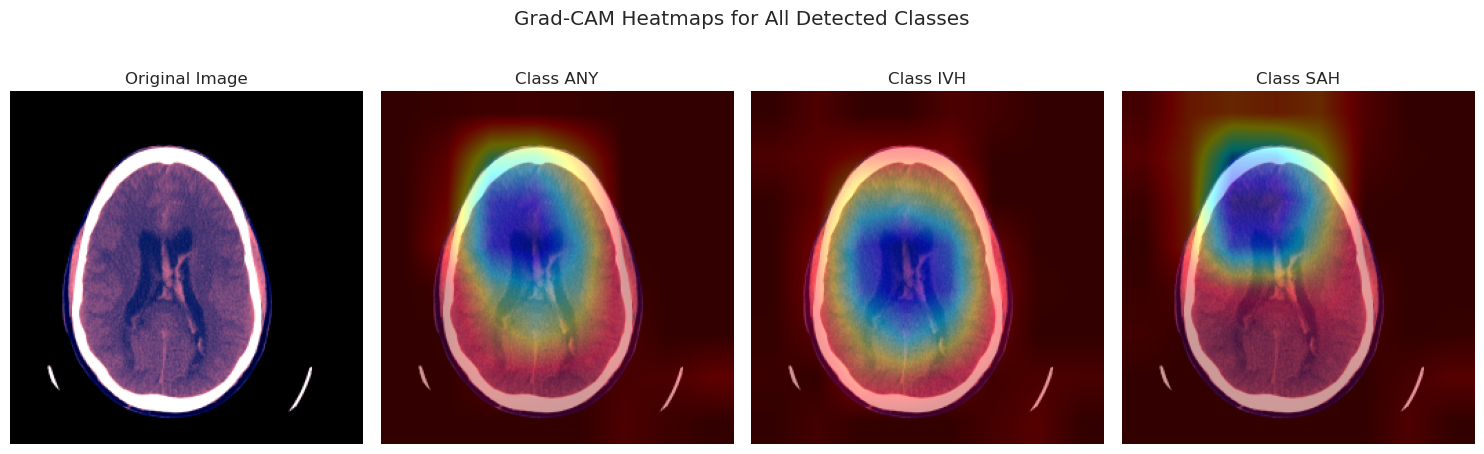

In [54]:
gc_y_pred = y_test_pred[6]
gc_img = x_test[6]
gc_y_pred_idx = np.argwhere(gc_y_pred >= 0.5).squeeze()
gradcam = GradCAM(model.model, last_conv_layer_name="top_conv")
heatmaps = gradcam.generate_heatmaps(gc_img, gc_img, gc_y_pred_idx)

fig, axes = plt.subplots(1, len(gc_y_pred_idx)+1, figsize=(15, 5))
axes[0].imshow(gc_img)
axes[0].set_title(f"Original Image")
axes[0].axis("off")

for i, class_idx in enumerate(gc_y_pred_idx, start=1):
    ax = axes[i]
    ax.imshow(heatmaps[class_idx])
    ax.set_title(f"Class {labels_map.get(class_idx)}")
    ax.axis("off")
    
plt.suptitle("Grad-CAM Heatmaps for All Detected Classes")
plt.tight_layout()
plt.show()